## Download data

In [1]:
!gdown --id 1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
!unzip -q "./datasets/FER-2013.zip"

/home/server1-ailab/miniconda3/envs/tuong_tf/lib/python3.8/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
From (redirected): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP&confirm=t&uuid=b9f36070-b9c7-4b05-922d-c121df10635d
To: /home/server1-ailab/Desktop/Tuong/Tensorflow_Tutorial/Machine_Learning/MLP/FER-2013.zip
100%|██████████████████████████████████████| 63.3M/63.3M [00:10<00:00, 5.90MB/s]


## Prepare data

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

2023-05-16 14:20:23.523753: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:20:24.342768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Dataloader

In [2]:
batch_size = 256
img_height = 48
img_width = 48
image_count = 28709 
train_dir = pathlib.Path("./datasets/FER_2013/train") 
test_dir = pathlib.Path("./datasets/FER_2013/test")   

list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

2023-05-16 14:20:27.804563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40991 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [3]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


#### Split data

In [4]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

normalized_train_ds = list_ds.skip(val_size)
normalized_val_ds = list_ds.take(val_size)

# number of data
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

22968
5741


#### Dataloader

In [5]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img, norm):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=1)
  # Resize the image to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # normalize
  if norm:
    img = img/127.5 - 1
  return img

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, norm=False)
  return img, label

def process_path_with_norm(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, norm=True)
  return img, label

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

normalized_train_ds = normalized_train_ds.map(process_path_with_norm, num_parallel_calls=AUTOTUNE)
normalized_val_ds = normalized_val_ds.map(process_path_with_norm, num_parallel_calls=AUTOTUNE)

# Check
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (48, 48, 1)
Label:  3


2023-05-16 14:20:29.985904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]
2023-05-16 14:20:29.986142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]


#### Cache + Prefetch

In [7]:
def configure_for_performance(ds, train):
  ds = ds.cache()
  if train:
    ds = ds.shuffle(buffer_size=512)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds2 = configure_for_performance(train_ds, train=True)
val_ds2 = configure_for_performance(val_ds, train=False)

normalized_train_ds2 = configure_for_performance(normalized_train_ds, train=True)
normalized_val_ds2 = configure_for_performance(normalized_val_ds, train=False)

### Visualize

2023-05-16 14:20:34.775930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]
2023-05-16 14:20:34.777287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]
2023-05-16 14:20:34.903624: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input p

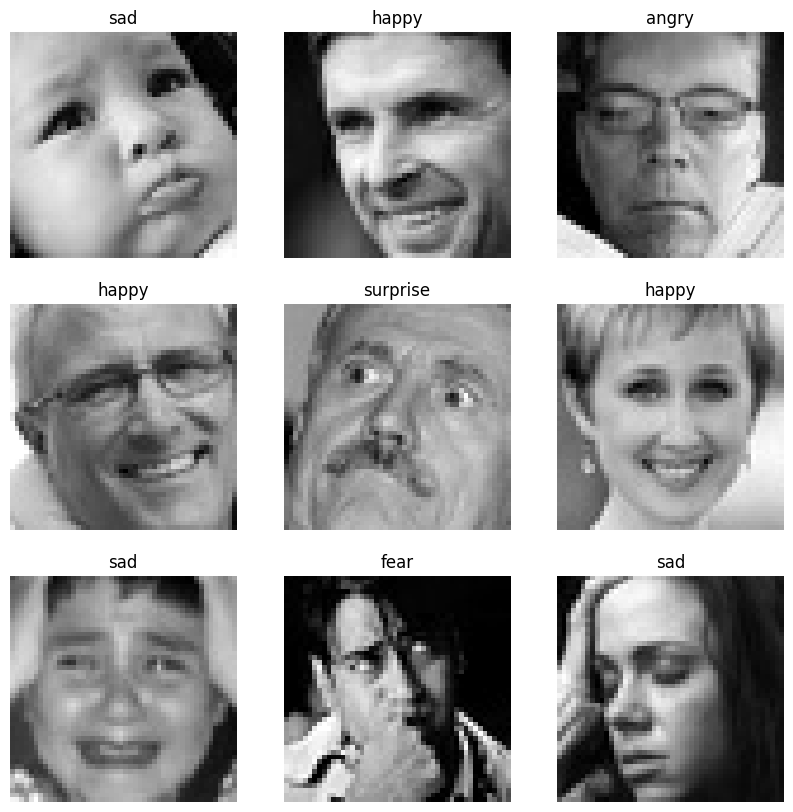

In [8]:
image_batch, label_batch = next(iter(train_ds2))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Training

### Softmax - Không Normalize

In [9]:
num_class = 7

#
FER_SR_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=num_class)
])
FER_SR_model.summary()
#
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)

FER_SR_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

#
FER_SR_history = FER_SR_model.fit(train_ds2, validation_data=val_ds2, epochs=100)

# Epoch 100/100
# 90/90 [==============================] - 0s 4ms/step - loss: 46728.1602 - accuracy: 0.2605 - val_loss: 41763.3398 - val_accuracy: 0.1918

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 7)                 16135     
                                                                 
Total params: 16,135
Trainable params: 16,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-05-16 14:20:41.553032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-16 14:20:41.562084: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4df4022220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 14:20:41.562111: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6


 1/90 [..............................] - ETA: 3:52 - loss: 641.9261 - accuracy: 0.0703

2023-05-16 14:20:41.797507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801
2023-05-16 14:20:41.896560: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/90 [============================>.] - ETA: 0s - loss: 86915.3516 - accuracy: 0.1766

2023-05-16 14:20:42.596603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]
2023-05-16 14:20:42.597108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]


90/90 [==============================] - 4s 11ms/step - loss: 86681.3281 - accuracy: 0.1764 - val_loss: 51754.6523 - val_accuracy: 0.2130
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 77501.1094 - accuracy: 0.1860 - val_loss: 82602.9609 - val_accuracy: 0.1146
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 71746.0234 - accuracy: 0.2014 - val_loss: 78474.1484 - val_accuracy: 0.1449
Epoch 4/100
90/90 [==============================] - 1s 8ms/step - loss: 64984.8203 - accuracy: 0.2097 - val_loss: 71251.7656 - val_accuracy: 0.2031
Epoch 5/100
90/90 [==============================] - 1s 7ms/step - loss: 65720.8984 - accuracy: 0.2092 - val_loss: 62950.8828 - val_accuracy: 0.2928
Epoch 6/100
90/90 [==============================] - 1s 7ms/step - loss: 59991.7617 - accuracy: 0.2224 - val_loss: 78817.4844 - val_accuracy: 0.1846
Epoch 7/100
90/90 [==============================] - 1s 7ms/step - loss: 62692.6914 - accuracy: 0.2191 - val_loss: 75

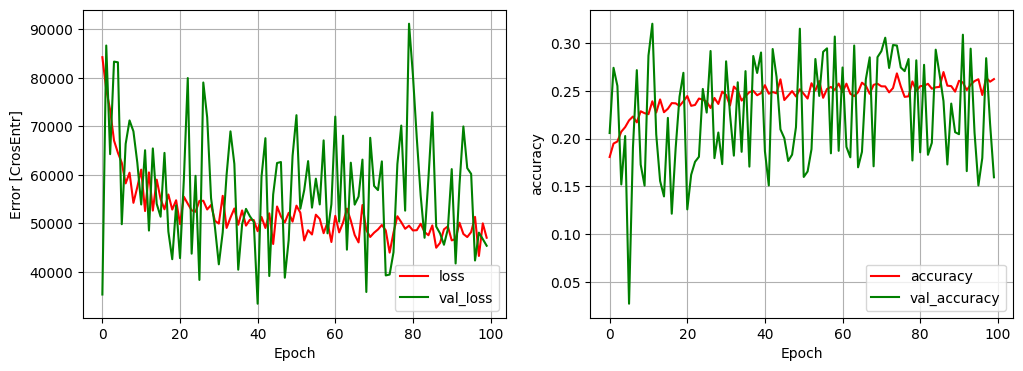

In [11]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(FER_SR_history.history['loss'], label='loss', color='red')
plt.plot(FER_SR_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(FER_SR_history.history['accuracy'], label='accuracy', color='red')
plt.plot(FER_SR_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)


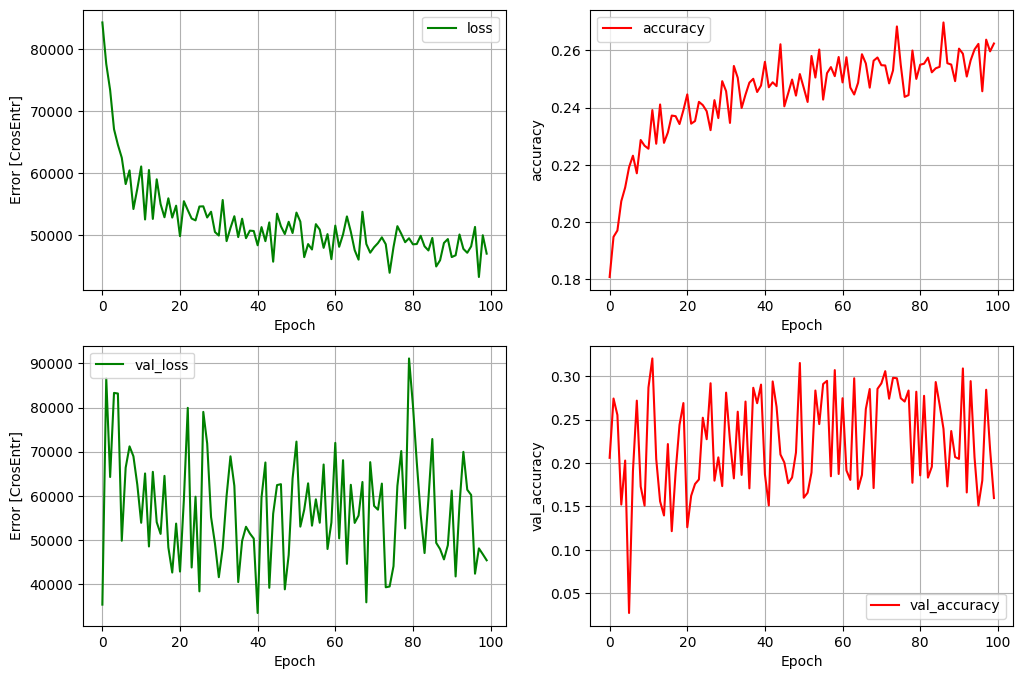

In [12]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(FER_SR_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(FER_SR_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(FER_SR_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(FER_SR_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)


In [13]:
hist = pd.DataFrame(FER_SR_history.history)
hist['epoch'] = FER_SR_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,48222.054688,0.262234,60204.609375,0.151019,95
96,51355.570312,0.245690,42368.472656,0.179760,96
97,43303.062500,0.263715,48102.257812,0.284271,97
98,50015.699219,0.259622,46780.355469,0.215990,98
99,47057.792969,0.262365,45403.921875,0.159554,99


In [14]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.2697230875492096
Max val acc:  0.3203274607658386
Min train loss:  43303.0625
Min val loss:  33461.79296875


### Softmax - Normalize

In [17]:
num_class = 7

# Create model
FER_SRN_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=num_class)
])

FER_SRN_model.summary()

# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)
# metric = tf.keras.metrics.SparseCategoricalAccuracy()
FER_SRN_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

# Training
FER_SRN_history = FER_SRN_model.fit(normalized_train_ds2, validation_data=normalized_val_ds2, epochs=100)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 16135     
                                                                 
Total params: 16,135
Trainable params: 16,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-05-16 14:24:23.081251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]
2023-05-16 14:24:23.081753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]


87/90 [============================>.] - ETA: 0s - loss: 1.9080 - accuracy: 0.2276

2023-05-16 14:24:24.558033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]
2023-05-16 14:24:24.558693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28709]
	 [[{{node Placeholder/_0}}]]


90/90 [==============================] - 2s 13ms/step - loss: 1.9065 - accuracy: 0.2272 - val_loss: 1.8303 - val_accuracy: 0.2613
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 1.8070 - accuracy: 0.2765 - val_loss: 1.7817 - val_accuracy: 0.2945
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 1.7649 - accuracy: 0.3040 - val_loss: 1.7561 - val_accuracy: 0.3121
Epoch 4/100
90/90 [==============================] - 1s 7ms/step - loss: 1.7395 - accuracy: 0.3194 - val_loss: 1.7396 - val_accuracy: 0.3254
Epoch 5/100
90/90 [==============================] - 1s 7ms/step - loss: 1.7220 - accuracy: 0.3302 - val_loss: 1.7284 - val_accuracy: 0.3304
Epoch 6/100
90/90 [==============================] - 1s 7ms/step - loss: 1.7092 - accuracy: 0.3389 - val_loss: 1.7204 - val_accuracy: 0.3372
Epoch 7/100
90/90 [==============================] - 1s 7ms/step - loss: 1.6993 - accuracy: 0.3434 - val_loss: 1.7139 - val_accuracy: 0.3402
Epoch 8/100
90/90 [=====

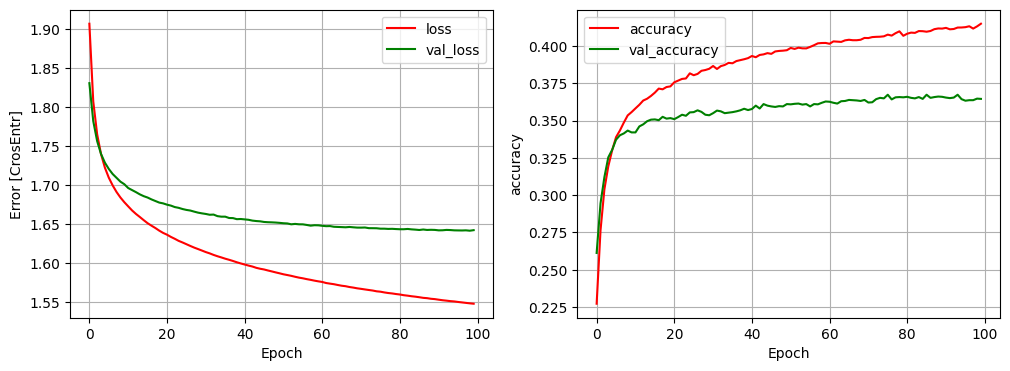

In [18]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(FER_SRN_history.history['loss'], label='loss', color='red')
plt.plot(FER_SRN_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(FER_SRN_history.history['accuracy'], label='accuracy', color='red')
plt.plot(FER_SRN_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)


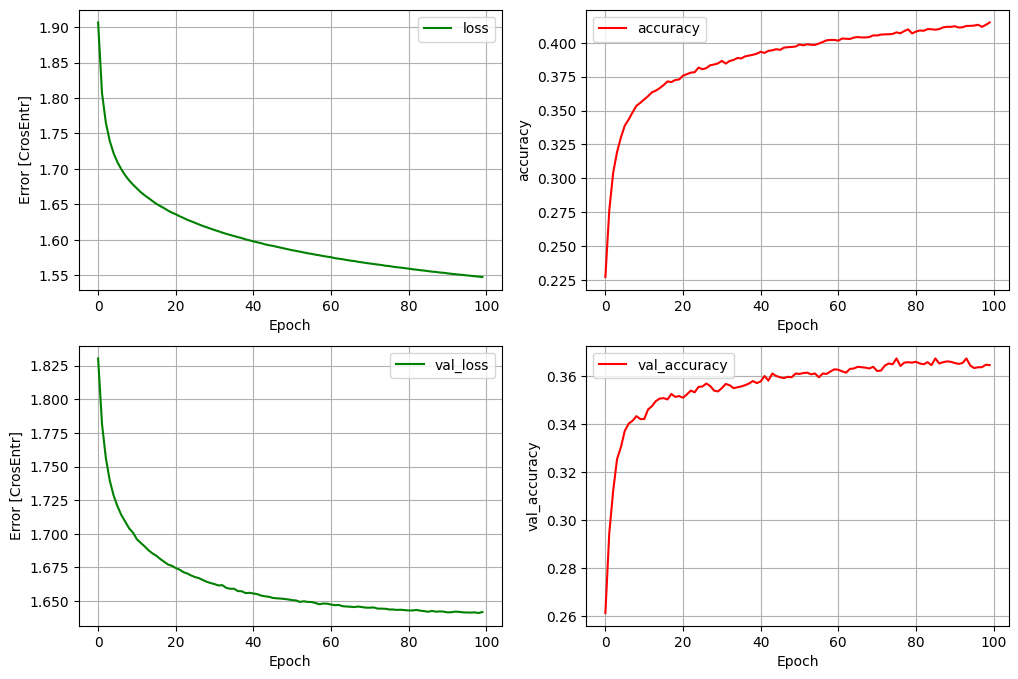

In [19]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(FER_SRN_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(FER_SRN_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(FER_SRN_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(FER_SRN_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)


In [20]:
hist = pd.DataFrame(FER_SRN_history.history)
hist['epoch'] = FER_SRN_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.549823,0.412661,1.641536,0.363351,95
96,1.549245,0.413271,1.641472,0.363700,96
97,1.548642,0.411703,1.641645,0.363700,97
98,1.548070,0.413184,1.641170,0.364745,98
99,1.547568,0.414969,1.641874,0.364571,99


In [21]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.4149686396121979
Max val acc:  0.36735761165618896
Min train loss:  1.5475678443908691
Min val loss:  1.6411700248718262


### MLP - tanh

In [22]:
# build model
num_class = 7

MLP_tanh_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=1024, activation='tanh'),
    tf.keras.layers.Dense(units=512, activation='tanh'),
    tf.keras.layers.Dense(units=256, activation='tanh'),
    tf.keras.layers.Dense(units=num_class)
])
##################################################################

MLP_tanh_model.summary()
# compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)
MLP_tanh_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

# training
MLP_tanh_history = MLP_tanh_model.fit(normalized_train_ds2, validation_data=normalized_val_ds2, epochs=100)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2360320   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 3,018,247
Trainable params: 3,018,247
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
90/90 [=========================

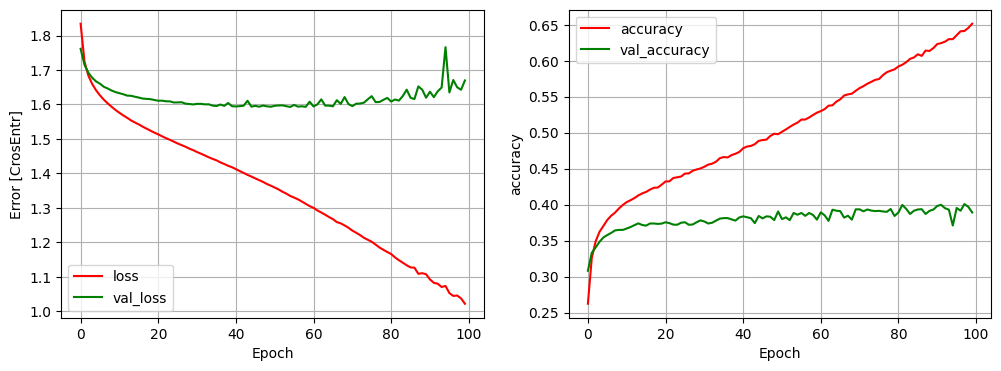

In [23]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='red')
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

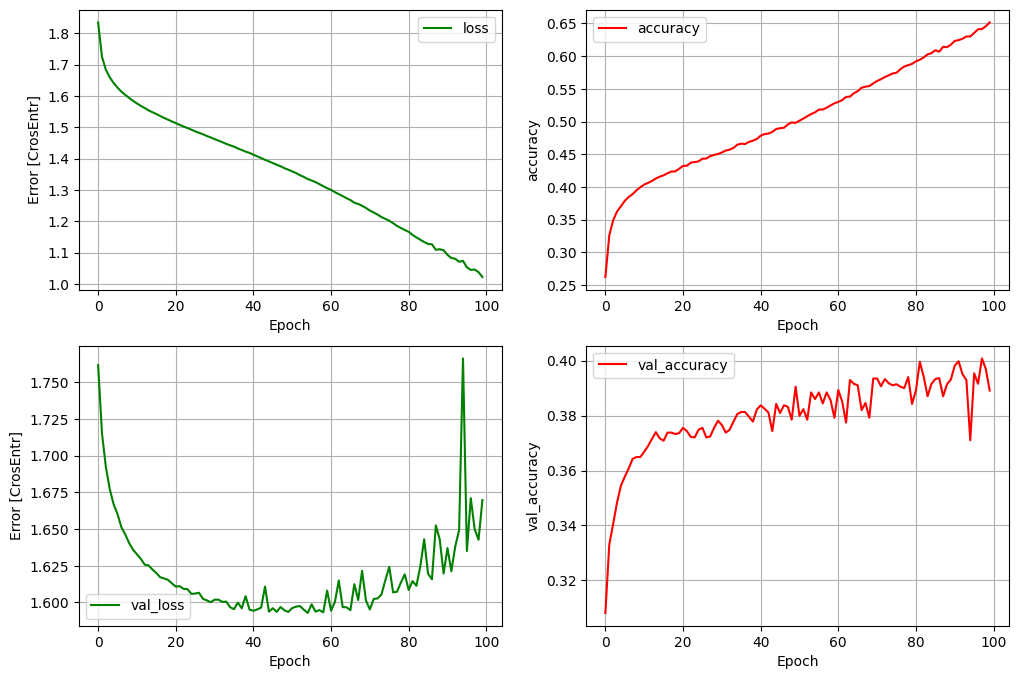

In [24]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)


In [25]:
hist = pd.DataFrame(MLP_tanh_history.history)
hist['epoch'] = MLP_tanh_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.052724,0.635406,1.635031,0.395402,95
96,1.044417,0.640935,1.671073,0.391569,96
97,1.045766,0.641327,1.650045,0.400801,97
98,1.037345,0.645594,1.642706,0.396969,98
99,1.021855,0.651428,1.669777,0.389131,99


In [26]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.6514281034469604
Max val acc:  0.40080124139785767
Min train loss:  1.021855354309082
Min val loss:  1.5928181409835815


### MLP - relu

In [27]:
# build model
num_class = 7

MLP_tanh_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=1024, activation="tanh"),
    tf.keras.layers.Dense(units=512, activation="tanh"),
    tf.keras.layers.Dense(units=256, activation="tanh"),
    tf.keras.layers.Dense(units=num_class)
])
MLP_tanh_model.summary()

# compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)

MLP_tanh_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

# training
MLP_tanh_history = MLP_tanh_model.fit(normalized_train_ds2, validation_data=normalized_val_ds2, epochs=100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 2304)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              2360320   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 3,018,247
Trainable params: 3,018,247
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
90/90 [=========================

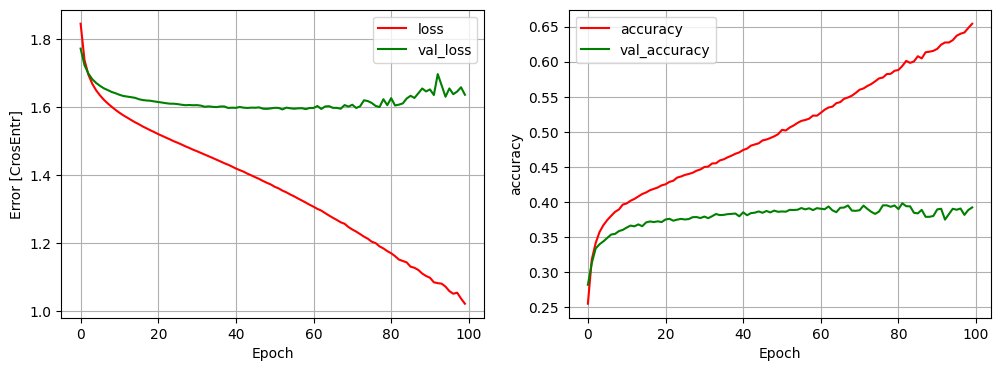

In [28]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='red')
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

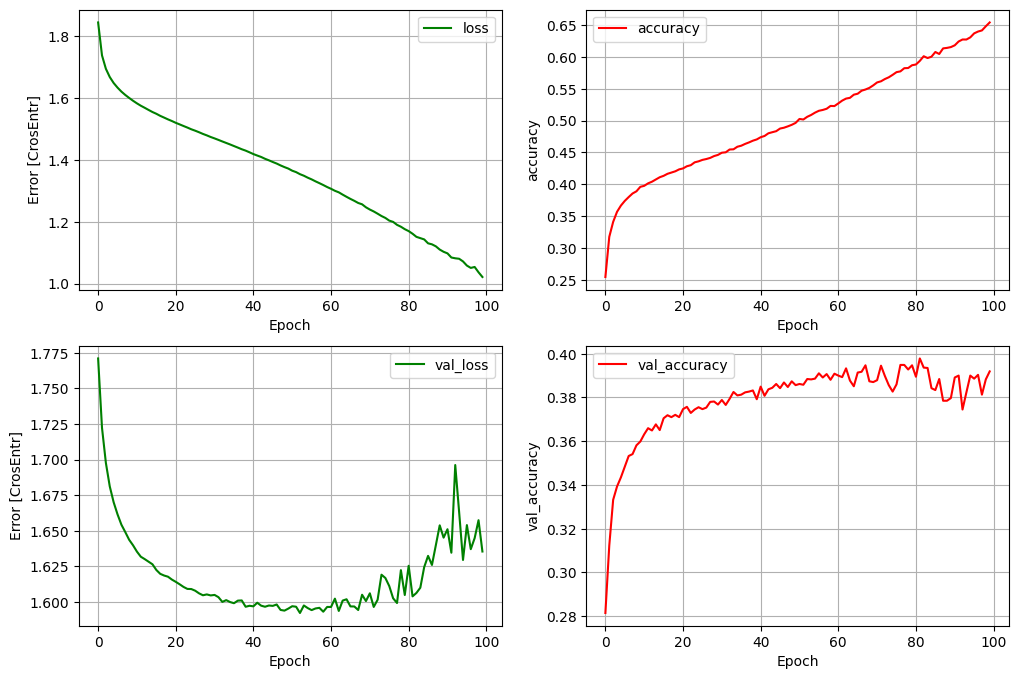

In [29]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)

In [30]:
hist = pd.DataFrame(MLP_tanh_history.history)
hist['epoch'] = MLP_tanh_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.058263,0.637104,1.654019,0.388608,95
96,1.050681,0.639977,1.637114,0.390350,96
97,1.053751,0.641719,1.644882,0.381292,97
98,1.036578,0.648206,1.657454,0.388260,98
99,1.021333,0.654258,1.635470,0.391918,99


In [31]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.6542580723762512
Max val acc:  0.39784008264541626
Min train loss:  1.0213334560394287
Min val loss:  1.5922930240631104
